In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns

In [2]:
# file_path = '/kaggle/input/burgers-solution-1000-v0-01/burger_solution_1000_0.01_upwind_scheme.npy' # change it accordingly
file_path = '../datasets/burgers_equation/burger_solution_1000_0.01_upwind_scheme.npy'

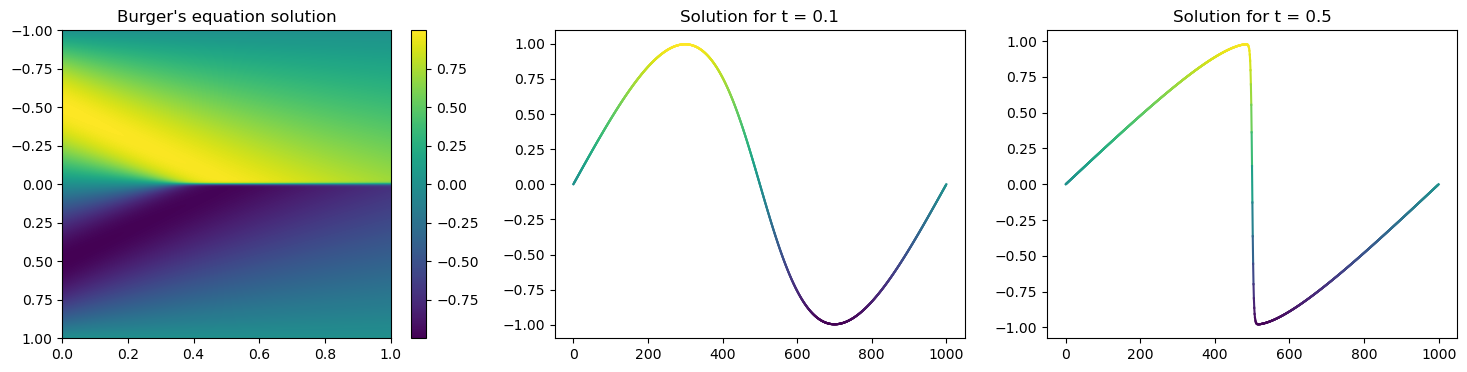

In [3]:
with open(file_path, 'rb') as f:
    # for d in data:
    #     print(d)
    usol =  np.load(f)
    usol = usol.T


    fig, ax = plt.subplots(1,3, figsize=(18,4))
    img = ax[0].imshow(usol, cmap='viridis', aspect='auto', extent=[0, 1, 1, -1])  # 'viridis' is just one of the available color maps
    fig.colorbar(img, ax=ax[0])
    
    x = np.linspace(0, usol.shape[0], usol.shape[0])
    y = usol[:,usol.shape[0]//10]
    y2 = usol[:,usol.shape[0]//2]
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(y.min(), y.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    for i in range(len(x) - 1):
        ax[1].plot(x[i:i+2], y[i:i+2], color=cmap(norm(y[i])))
        
    for i in range(len(x) - 1):
        ax[2].plot(x[i:i+2], y2[i:i+2], color=cmap(norm(y2[i])))
        
    ax[0].set_title("Burger's equation solution")
    ax[1].set_title(f'Solution for t = 0.1')
    ax[2].set_title(f'Solution for t = 0.5')
    
    plt.show()
    fig.savefig('./burgers_equation_v=0.01.pdf')

In [4]:
sampler = qmc.LatinHypercube(d=2)
sample_pos = sampler.random(n=5000)
sample_neg = sampler.random(n=5000)
sample_neg[:,0] = -sample_neg[:,0]

sample = np.vstack([sample_pos, sample_neg])
# print(sample.shape)

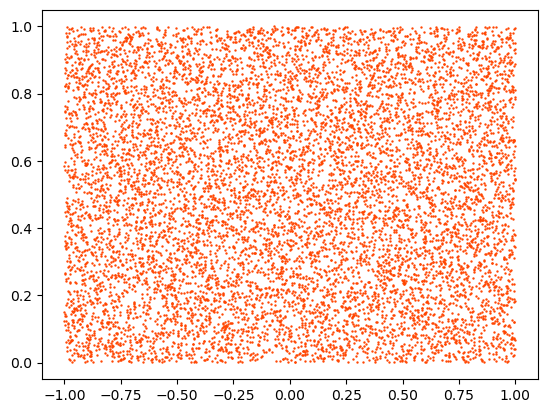

In [5]:
plt.scatter(sample[:,0], sample[:,1], s=0.5, color='orangered')

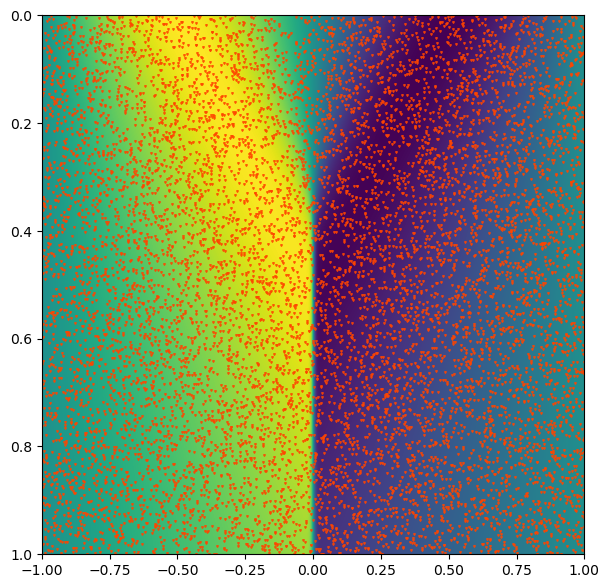

In [6]:
with open(file_path, 'rb') as f:
    usol =  np.load(f)
    fig, ax = plt.subplots(1, figsize=(7,7))
    img = ax.imshow(usol, cmap='viridis', aspect='auto', extent=[-1, 1, 1, 0])
    ax.scatter(sample[:,0], sample[:,1], s=1, color='orangered', marker='v')

#### Visualize learned functions

In [7]:
class ScalingLayer(nn.Module):
    def __init__(self, scale_init_value=1, bias_init_value=0):
        super().__init__()
        self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
        self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

    def forward(self, input):
        return input * self.scale + self.bias
    
    
class U(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class F(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(ScalingLayer())
        for hidden in hidden_shapes:
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Sigmoid())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
file_u = f'../upinn_models/burgers/burgers_more_traindata/u_burgers_LBFGS_good.pt'
file_f = f'../upinn_models/burgers/burgers_more_traindata/f_burgers_LBFGS_good.pt'
u = U(2,1, [20]*8)
checkpoint = torch.load(file_u, map_location=torch.device('cpu'))
u.load_state_dict(checkpoint)# 
u.eval()

f = F(3,1, [20]*8)
checkpoint = torch.load(file_f, map_location=torch.device('cpu'))
f.load_state_dict(checkpoint)# 
f.eval()

F(
  (layers): ModuleList(
    (0): ScalingLayer()
    (1): Linear(in_features=3, out_features=20, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=20, out_features=20, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=20, out_features=20, bias=True)
    (12): Sigmoid()
    (13): Linear(in_features=20, out_features=20, bias=True)
    (14): Sigmoid()
    (15): Linear(in_features=20, out_features=20, bias=True)
    (16): Sigmoid()
    (17): Linear(in_features=20, out_features=1, bias=True)
  )
)

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c']


Text(0.5, 0, 'x')

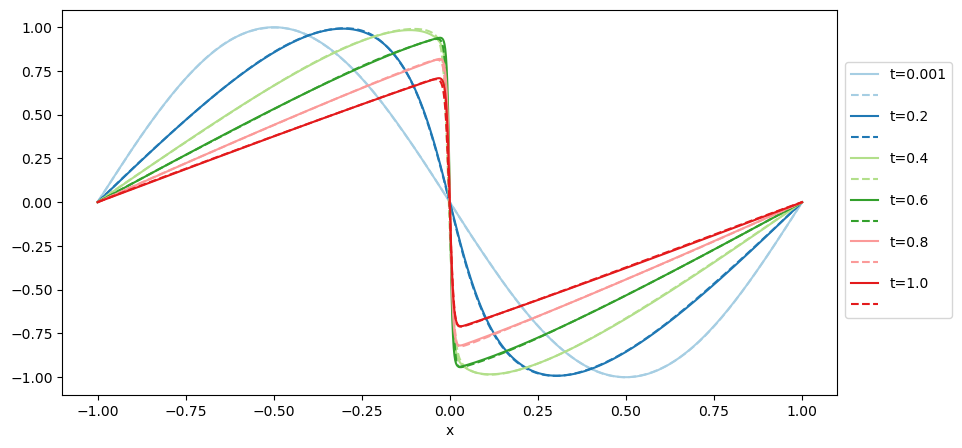

In [130]:
# colors = ['royalblue', 'forestgreen', 'darkorange', 'firebrick', 'blueviolet', 'gold']
time_steps = [0,199,399,599,799,999]
import matplotlib.colors as mcolors
cmap = plt.get_cmap('Paired')
num_colors = len(time_steps)
colors = [mcolors.to_hex(cmap(i)) for i in range(num_colors)]
print(colors)

fig, ax = plt.subplots(1,figsize=(10,5))
for i,j in enumerate(time_steps):
    ax.plot(np.linspace(-1, 1, 1000), usol[j,:], label=f't={(j+1)/usol.shape[0]}', color=colors[i])
    in_data_x = torch.linspace(-1, 1, 1000).reshape(-1,1)
    in_data_t = torch.ones_like(in_data_x)*(j/1000)
    in_data = torch.concatenate([in_data_t, in_data_x], dim=1)
    u_out = u(in_data)

    ax.plot(np.linspace(-1, 1, 1000), u_out.detach().numpy(), linestyle='--',color=colors[i], label=f' ')
ax.legend(loc=(1.01,0.2))
ax.set_xlabel('x')

In [10]:
usol.shape

(1000, 1000)

## Surrogate solution's MSE

In [11]:
mesh_size = usol.shape[0]

t_phys = np.linspace(0, 1, mesh_size)
x_phys = np.linspace(-1, 1, mesh_size)
x_mesh, t_mesh = np.meshgrid(x_phys, t_phys)

coordinates = np.vstack((t_mesh.flatten(), x_mesh.flatten())).T
coordinates = torch.Tensor(coordinates).requires_grad_(True)
            
u_p = u(coordinates)
u_mesh = u_p.reshape(x_mesh.shape)

In [12]:
mse_u = nn.MSELoss()(u_mesh, torch.Tensor(usol))

In [13]:
print(f'MSE of UPINNs surrogated solutiuon and grounth truth is: {mse_u }')

MSE of UPINNs surrogated solutiuon and grounth truth is: 0.00018893337983172387


## MSE of Unknown component (approximated by F)

In [14]:
dudxt = torch.autograd.grad(u_p, coordinates, torch.ones_like(u_p))[0]
dudx = dudxt[:,1]
dudt = dudxt[:,0]


In [15]:
expected_hidden = -u_p * dudx.reshape(-1,1)

In [16]:
f_input = torch.concatenate([u_p, dudt.reshape(-1,1), dudx.reshape(-1,1)], axis=1)
f_out = f(f_input)

In [17]:
mse_f = nn.MSELoss()(f_out, expected_hidden)

In [88]:
# use this in both of the following heatmaps to have the same range
vmin = min(expected_hidden.min(), f_out.min())
vmax = max(expected_hidden.max(), f_out.max())
print()

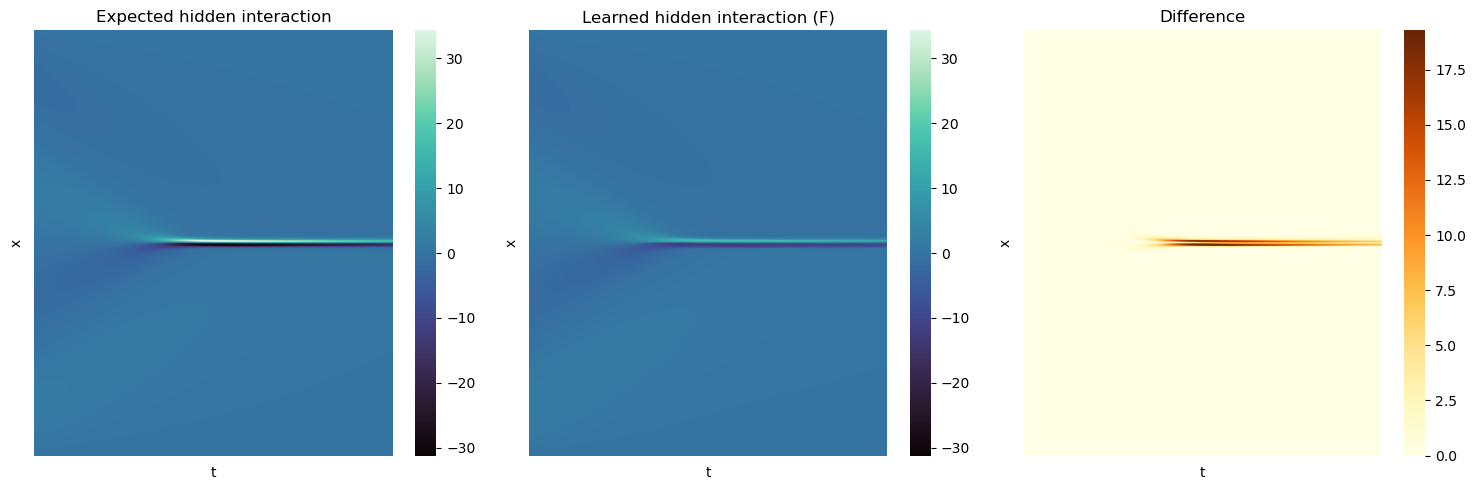

In [98]:
fig_hidden, ax_hidden = plt.subplots(1,3, figsize=(15,5))
df_expected = pd.DataFrame.from_dict(np.array([coordinates[:,1].detach().numpy(),
                                           coordinates[:,0].detach().numpy(), 
                                           expected_hidden.reshape(-1).detach().numpy()]).T)
df_expected.columns = ['X_value','Y_value','Z_value']
df_expected_pivot = df_expected.pivot('X_value','Y_value','Z_value')
heatmap1 = sns.heatmap(df_expected_pivot, cmap="mako", vmin=vmin, vmax=vmax, ax=ax_hidden[0])
ax_hidden[0].set_xticks([])
ax_hidden[0].set_yticks([])
ax_hidden[0].set(xlabel='t')
ax_hidden[0].set(ylabel='x')
ax_hidden[0].set_title('Expected hidden interaction')

df_learned = pd.DataFrame.from_dict(np.array([coordinates[:,1].detach().numpy(),
                                           coordinates[:,0].detach().numpy(), 
                                           f_out.reshape(-1).detach().numpy()]).T)
df_learned.columns = ['X_value','Y_value','Z_value']
df_learned_pivot = df_learned.pivot('X_value','Y_value','Z_value')
heatmap2 = sns.heatmap(df_learned_pivot, cmap="mako", vmin=vmin, vmax=vmax, ax=ax_hidden[1])
ax_hidden[1].set_xticks([])
ax_hidden[1].set_yticks([])
ax_hidden[1].set(xlabel='t')
ax_hidden[1].set(ylabel='x')
ax_hidden[1].set_title('Learned hidden interaction (F)')


diff = np.abs(expected_hidden.reshape(-1).detach().numpy() - f_out.reshape(-1).detach().numpy())
df_diff = pd.DataFrame.from_dict(np.array([coordinates[:,1].detach().numpy(),
                                           coordinates[:,0].detach().numpy(), 
                                           diff]).T)
df_diff.columns = ['X_value','Y_value','Z_value']
df_diff_pivot = df_diff.pivot('X_value','Y_value','Z_value')

heatmap3 = sns.heatmap(df_diff_pivot,cmap="YlOrBr", ax=ax_hidden[2])
ax_hidden[2].set_xticks([])
ax_hidden[2].set_yticks([])
ax_hidden[2].set(xlabel='t')
ax_hidden[2].set(ylabel='x')
ax_hidden[2].set_title('Difference')

# Adjust layout
plt.tight_layout()
# fig_hidden.savefig('../imgs/burgers/hidden_interaction.png') # too heavy for pdf